In [33]:
import time
from collections import deque

# -------- Image processing -----
import pyautogui
import numpy as np
import cv2
import mss

# -------- TensorFlow / Keras ----
import tensorflow as tf
from tensorflow.keras import layers, Model

# -------- Misc / Debug ----------
import matplotlib.pyplot as plt

print("All imports successful for Run3 project!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")


All imports successful for Run3 project!
TensorFlow version: 2.15.0
NumPy version: 1.26.4
OpenCV version: 4.10.0


In [51]:
#Establish some variables and params for later

#number of frames to feed model at a time. We input to the model the FRAME_STACK most recent frames
FRAME_STACK = 4

#variables for the location of the run 3 game on the screen. This is for Malcolms computer, if its diff for u make new vars
TOP_X = 275
TOP_Y = 195
WIDTH = 725
HEIGHT = 545

GAMEOVER_X = 860
GAMEOVER_Y = 435
GAMEOVER_W = 70
GAMEOVER_H = 45

RUNWAY_X = 600
RUNWAY_Y = 480
RUNWAY_W = 135
RUNWAY_H = 230

#Which device is running the game. Add ur own if u wanna train. So we dont have to go all the way through everything and change
MAC_LAPTOP = True 
MAC_MONITOR = False

if MAC_LAPTOP: 
    TOP_X = 275
    TOP_Y = 195
    WIDTH = 725
    HEIGHT = 545

    GAMEOVER_X = 860
    GAMEOVER_Y = 435
    GAMEOVER_W = 70
    GAMEOVER_H = 45

    RUNWAY_X = 590
    RUNWAY_Y = 450
    RUNWAY_W = 100
    RUNWAY_H = 150


#resolution of the image were resizing to. This affects the input to our neural net directly.
RESOLUTION = 128

#number of actions the model can take. This is a super important thing to change if the model isnt training well. As of 12/5 were starting
#with the model being able to take [no action, L_small, R_small, U_small, L_med, R_med ...etc.]
NUM_ACTIONS = 10


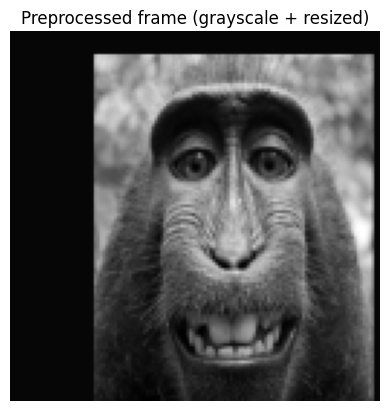

In [36]:
def preprocess_frame(image, resize=(RESOLUTION, RESOLUTION), gray=True):
    """
    Captures a screenshot of the given region, converts to grayscale, resizes.
    Returns numpy array of shape (resize[1], resize[0]).
    """
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize deterministically
    small = cv2.resize(image, resize, interpolation=cv2.INTER_AREA)
    
    return small

def stack_frames(frames, new_frame, stack_size=FRAME_STACK):
    """
    Maintains a stack of frames to capture motion.
    frames: deque of previous frames
    new_frame: newest preprocessed frame
    Returns stack of frames
    """
    if len(frames) == 0:
        # Initialize with repeated frame
        for _ in range(stack_size):
            frames.append(new_frame)
    else:
        frames.append(new_frame)
        if len(frames) > stack_size:
            frames.popleft()
    return np.stack(frames, axis=0)

#TEST to see if screen grab is working

time.sleep(3)

sct = mss.mss()
monitor = {
    "top": TOP_Y,
    "left": TOP_X,
    "width": WIDTH,
    "height": HEIGHT
}
screenshot = np.array(sct.grab(monitor))
img = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGRA2BGR)
processed = preprocess_frame(img)
plt.imshow(processed, cmap="gray")
plt.title("Preprocessed frame (grayscale + resized)")
plt.axis("off")
plt.show()

In [ ]:
class PPOActorCritic(tf.keras.Model):
    def __init__(self, input_channels=FRAME_STACK, num_actions=NUM_ACTIONS):
        super(PPOActorCritic, self).__init__()

        # TensorFlow expects channels-last → (RESOLUTION, RESOLUTION, C)
        self.input_channels = input_channels
        self.num_actions = num_actions
        
        # ---------- CNN Backbone ----------
        self.conv1 = layers.Conv2D(32, kernel_size=8, strides=4, activation='relu')
        self.conv2 = layers.Conv2D(64, kernel_size=4, strides=2, activation='relu')
        self.conv3 = layers.Conv2D(64, kernel_size=3, strides=1, activation='relu')

        #max pool? think about max pool if we use a larger resolution. But these convs also scale down.

        # compute flatten size
        self._conv_out_size = self._get_conv_out((RESOLUTION, RESOLUTION, input_channels))

        # ---------- Shared Fully Connected ----------
        self.fc = layers.Dense(512, activation='relu')

        # ---------- Actor Head ----------
        self.actor_fc1 = layers.Dense(64, activation='relu')
        self.actor_logits = layers.Dense(num_actions, activation=None)

        # ---------- Critic Head ----------
        self.critic_fc1 = layers.Dense(64, activation='relu')
        self.critic_value = layers.Dense(1, activation=None)

    # -------------------------------------------------
    # Compute conv output size by running dummy tensor. This saves us work if we change the CNN structure
    # -------------------------------------------------
    def _get_conv_out(self, shape):
        dummy = tf.zeros((1, *shape), dtype=tf.float32)
        x = self.conv1(dummy)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(np.prod(x.shape[1:]))

    # -------------------------------------------------
    # Forward pass
    # -------------------------------------------------
    def call(self, x):
        """
        x expected as (batch, RESOLUTION, RESOLUTION, 4)
        """
        x = tf.cast(x, tf.float32) / 255.0 #normalize to [0,1]

        # CNN backbone
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = tf.reshape(x, (x.shape[0], -1))

        # Shared FC
        x = self.fc(x)

        # ---- Actor ----
        a = self.actor_fc1(x)
        logits = self.actor_logits(a)

        # ---- Critic ----
        c = self.critic_fc1(x)
        value = self.critic_value(c)

        return logits, value

In [64]:
class Run3Env:
    def __init__(self, region=(TOP_X, TOP_Y, WIDTH, HEIGHT), frame_stack=FRAME_STACK):
        self.region = region
        self.frame_stack = frame_stack #integer, not the actual stack. Do we need instance var?
        self.frames = deque(maxlen=frame_stack)

        self.sct = mss.mss()
        self.monitor = {
            "top": region[1],      # TOP_Y
            "left": region[0],     # TOP_X
            "width": region[2],    # WIDTH
            "height": region[3]    # HEIGHT
        }

    # -------------------------
    # Reset environment
    # -------------------------
    def reset(self):
        # Click to restart game. 900,650 is just off the screen a bit, click twice to bypass the "continue" and "score". 
        #we can also press a button to make it better for everyones computer
        time.sleep(.7)
        pyautogui.click(900, 650)
        time.sleep(.7)
        pyautogui.click(900, 650)
        self.frames.clear()

        # Get initial observation
        raw = self.capture_raw()
        processed = preprocess_frame(raw) #function defined at the top
        stacked = stack_frames(self.frames, processed)
        return np.transpose(stacked, (1, 2, 0))  # (RESOLUTION, RESOLUTION, FRAME_STACK). 

    # -------------------------
    # Capture raw screenshot
    # -------------------------
    def capture_raw(self):
        screenshot = np.array(self.sct.grab(self.monitor))
        # mss returns BGRA, convert to BGR. Also mss is much faster than pyautogui so we use it for more fps.
        img = cv2.cvtColor(screenshot, cv2.COLOR_BGRA2BGR)
        return img

    # -------------------------
    # Detect game over
    # -------------------------
    def game_over(self, raw_frame): #FIX
        """Check if dialog region is white"""
        # Extract region. Note hard coded values are for macs laptop, its a region of the screen where its all white on game over.
        tlx = GAMEOVER_X - TOP_X
        tly = GAMEOVER_Y - TOP_Y
        w = GAMEOVER_W
        h = GAMEOVER_H
        roi = raw_frame[tly:tly+h, tlx:tlx+w]
        
        # Check if white directly on BGR image
        mean_val = roi.mean()  # Average across all pixels AND all channels
        
        # If all channels are ~255, mean will be ~255
        return mean_val > 250

    def runway_reward(self, raw_frame):
        tlx = RUNWAY_X - TOP_X
        tly = RUNWAY_Y - TOP_Y
        w = RUNWAY_W
        h = RUNWAY_H
        roi = raw_frame[tly:tly+h, tlx:tlx+w]

        if len(roi.shape) == 3: #grayscale
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        else:
            roi_gray = roi
        
        platform_pixels = np.sum(roi_gray > 30)
        total_pixels = roi_gray.size
        platform_ratio = platform_pixels / total_pixels
        
        return platform_ratio * 0.25 #small reward based on % of runway occupied.

    # -------------------------
    # Take one step in environment 
    # -------------------------
    def step(self, action): #NOT FINISHED DONT TOUCH
        # step_start = time.time()
        self._execute_action(action)

        # Capture new frame
        raw = self.capture_raw()

        done = self.game_over(raw) #Boolean var

        # Reward logic
        if done:
            reward = -50
        else:
            reward = 1 + self.runway_reward(raw) # small survival reward + a small alignment reward

        # Preprocess
        processed = preprocess_frame(raw)
        stacked = stack_frames(self.frames, processed)
        
        state = np.transpose(stacked, (1, 2, 0))  # (REOSLUTION,RESOLUTION,STACK_FRAMES)

        # TARGET_TIMESTEP = 0.33 
        # elapsed = time.time() - step_start
        # if elapsed < TARGET_TIMESTEP:
        #     time.sleep(TARGET_TIMESTEP - elapsed)

        return state, reward, done, {}

    def _execute_action(self, action):
        """Execute action with proper hold durations"""
        # Map actions to (key, duration_seconds)
        action_config = {
            0: (None, 0),           # No action
            1: ('left', 0.05),       # Left short - 100ms
            2: ('right', 0.05),      # Right short
            3: ('up', 0.05),         # Up short (jump)
            4: ('left', 0.1),      # Left medium - 250ms
            5: ('right', 0.1),     # Right medium
            6: ('up', 0.1),        # Up medium
            7: ('left', 0.25),       # Left long - 500ms
            8: ('right', 0.25),      # Right long
            9: ('up', 0.25),         # Up long
        }
        
        key, duration = action_config[action]
        
        if key is not None:
            pyautogui.keyDown(key)
            time.sleep(duration)
            pyautogui.keyUp(key)
        time.sleep(0.25-duration)

In [63]:
#JUST FOR TESTING THINGS WORK WHEN RUNNING THE GAME.
sct = mss.mss()
monitor = {
    "top": TOP_Y,
    "left": TOP_X,
    "width": WIDTH,
    "height": HEIGHT
}
num_g_over = 0

def test_game_over(raw_frame):
    """Check if dialog region is white"""
    # Extract region
    tlx = 860 - TOP_X
    tly = 435 - TOP_Y
    w = 70
    h = 45
    roi = raw_frame[tly:tly+h, tlx:tlx+w]
    
    # Check if white directly on BGR image
    mean_val = roi.mean()  # Average across all pixels AND all channels
    
    # If all channels are ~255, mean will be ~255
    return mean_val > 250

def test_runway_reward(raw_frame):
    tlx = RUNWAY_X - TOP_X
    tly = RUNWAY_Y - TOP_Y
    w = RUNWAY_W
    h = RUNWAY_H
    roi = raw_frame[tly:tly+h, tlx:tlx+w]

    if len(roi.shape) == 3: #grayscale
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    else:
        roi_gray = roid
    
    platform_pixels = np.sum(roi_gray > 30)
    total_pixels = roi_gray.size
    platform_ratio = platform_pixels / total_pixels
    
    return platform_ratio

while True:
    start_time = time.time()
    screenshot = np.array(sct.grab(monitor))
    img = cv2.cvtColor(screenshot, cv2.COLOR_BGRA2BGR)
    if test_game_over(img):
        num_g_over += 1
        print(f"\rgame over {num_g_over}", end='', flush=True)
        time.sleep(0.7)
        pyautogui.click(900, 650)
        time.sleep(0.7)
        pyautogui.click(900, 650)
    else:
        pass
        # print(test_runway_reward(img))
    elapsed = time.time() - start_time
    if elapsed < 1:
            time.sleep(1 - elapsed)


game over 4

KeyboardInterrupt: 

In [ ]:
#IHAVENT CHECKED THE CLASS BELOW YET THIS IS JUST CHAT SO DONT TREAT IT AS SOLIDLY IMPLEMENTED

class PPOBuffer:
    def __init__(self, size, obs_shape, gamma=0.99, lam=0.95):
        """
        size      : number of steps per rollout
        obs_shape : shape of observation e.g. (RESOLUTION, RESOLUTION, FRAME_STACK)
        gamma     : discount factor
        lam       : GAE lambda
        """
        self.size = size
        self.gamma = gamma
        self.lam = lam

        # Allocate buffers
        self.obs_buf = np.zeros((size, *obs_shape), dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.int32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)

        # To be computed later
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)

        self.ptr = 0        # next index to write
        self.path_start = 0 # start index of current trajectory

    # ---------------------------------------------------------
    # Store one step of rollout data
    # ---------------------------------------------------------
    def store(self, obs, act, rew, done, val, logp):
        assert self.ptr < self.size, "PPOBuffer overflow!"
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    # ---------------------------------------------------------
    # Finish trajectory and compute GAE + returns
    # last_val is the value of the final observation (0 if done)
    # ---------------------------------------------------------
    def finish_trajectory(self, last_val=0):
        """
        Called at trajectory end or when episode completes.
        Computes GAE advantage & discounted returns.
        """
        i1 = self.path_start
        i2 = self.ptr

        rewards = np.append(self.rew_buf[i1:i2], last_val)
        values  = np.append(self.val_buf[i1:i2], last_val)

        # GAE-Lambda advantage calculation
        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        adv = np.zeros_like(deltas)
        last_gae = 0
        for t in reversed(range(len(deltas))):
            last_gae = deltas[t] + self.gamma * self.lam * last_gae * (1 - self.done_buf[i1 + t])
            adv[t] = last_gae

        self.adv_buf[i1:i2] = adv
        self.ret_buf[i1:i2] = adv + self.val_buf[i1:i2]

        self.path_start = self.ptr  # next trajectory starts here

    # ---------------------------------------------------------
    # Retrieve all data, normalize adv, and reset pointer
    # ---------------------------------------------------------
    def get(self, batch_size=64):
        """Returns batches of rollout data."""
        assert self.ptr == self.size, "Buffer not full!"

        # Normalize advantages
        adv_mean = self.adv_buf.mean()
        adv_std = self.adv_buf.std() + 1e-8
        self.adv_buf = (self.adv_buf - adv_mean) / adv_std

        # Shuffle indices for mini-batches
        indices = np.arange(self.size)
        np.random.shuffle(indices)

        for start in range(0, self.size, batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            yield (
                self.obs_buf[batch_idx],
                self.act_buf[batch_idx],
                self.adv_buf[batch_idx],
                self.ret_buf[batch_idx],
                self.logp_buf[batch_idx],
                self.val_buf[batch_idx]
            )

        self.ptr = 0
        self.path_start = 0
